# Step 6: Filter out incoherent matches

In [31]:
import os
from functools import partial
import numpy as np
from phathom import plotting
from phathom.registration import registration as reg
from phathom.registration.pcloud import estimate_affine, register_pts
from phathom.utils import pickle_save, read_voxel_size

In [32]:
working_dir = '/media/jswaney/Drive/Justin/marmoset'
voxel_size = read_voxel_size(os.path.join(working_dir, 'voxel_size.csv'))  # z, y, x
voxel_size

(2.0, 1.8, 1.8)

In [33]:
# Load blobs
fixed_pts_path = 'round1/blobs.npy'
moving_pts_path = 'round2/blobs.npy'

fixed_pts = np.load(os.path.join(working_dir, fixed_pts_path))
moving_pts = np.load(os.path.join(working_dir, moving_pts_path))
print('keypoints:', fixed_pts.shape, moving_pts.shape)

keypoints: (27449319, 3) (27572651, 3)


In [34]:
# Load matches
idx_fixed_path = 'round1/match_idx.npy'
idx_moving_path = 'round2/match_idx.npy'

idx_fixed = np.load(os.path.join(working_dir, idx_fixed_path))
idx_moving = np.load(os.path.join(working_dir, idx_moving_path))
print('# matches loaded:', idx_fixed.shape[0])

# matches loaded: 52704


In [35]:
# Extract matching coordinates
fixed_keypts = fixed_pts[idx_fixed]
moving_keypts = moving_pts[idx_moving]

In [36]:
# Convert to um
fixed_keypts_um = fixed_keypts * np.asarray(voxel_size)
moving_keypts_um = moving_keypts * np.asarray(voxel_size)

<IPython.core.display.Javascript object>


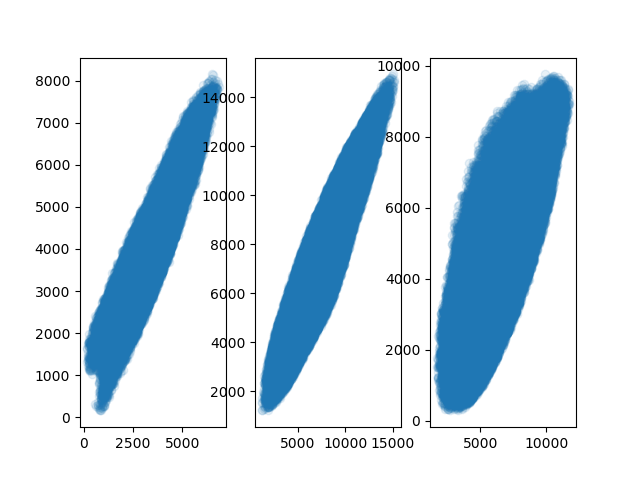

In [37]:
# Show starting coordinate similarity
plotting.plot_correspondence(fixed_keypts_um, moving_keypts_um)

<IPython.core.display.Javascript object>


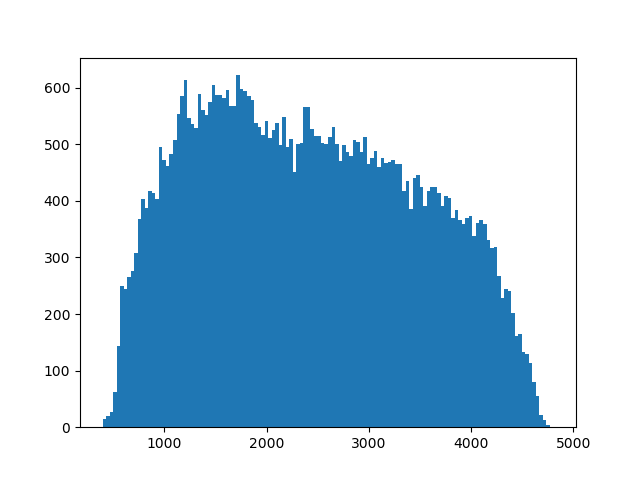

Starting ave. distance [um]: 2419.7946172


In [38]:
# Show starting residuals
starting_residuals = reg.match_distance(fixed_keypts_um,
                                        moving_keypts_um)
plotting.plot_hist(starting_residuals, 128)
print('Starting ave. distance [um]:', starting_residuals.mean())

In [39]:
# Use RANSAC to estimate affine transformation
resid_thresh = None
min_samples = 30

ransac, ransac_inliers = estimate_affine(fixed_keypts_um,
                                         moving_keypts_um,
                                         'ransac',
                                         min_samples,
                                         resid_thresh)

In [40]:
# Apply affine transformation
ransac_keypts_um = register_pts(fixed_keypts_um, ransac)

<IPython.core.display.Javascript object>


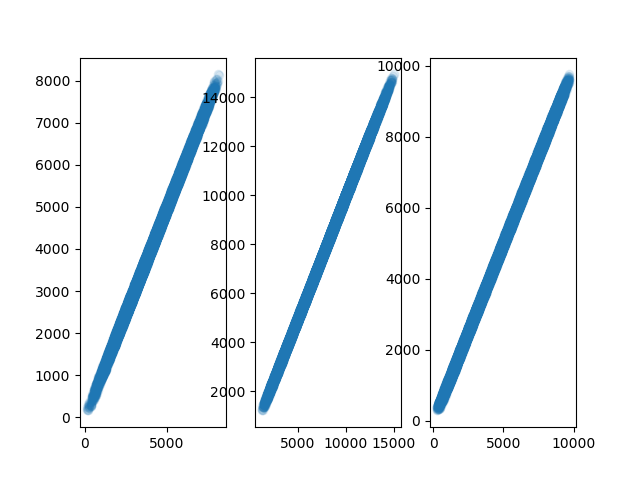

In [41]:
# Show ransac coordinate similarity
plotting.plot_correspondence(ransac_keypts_um, moving_keypts_um)

<IPython.core.display.Javascript object>


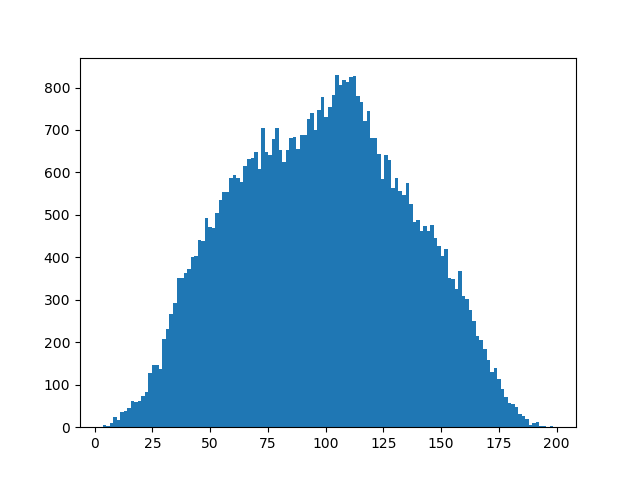

RANSAC ave. distance [um]: 98.1395622818


In [42]:
# Show residuals after ransac
ransac_residuals = reg.match_distance(ransac_keypts_um,
                                      moving_keypts_um)
plotting.plot_hist(ransac_residuals, 128)
print('RANSAC ave. distance [um]:', ransac_residuals.mean())

In [13]:
# Aside: save residuals to excel
import pandas as pd

In [14]:
df = pd.DataFrame({'coarse': starting_residuals, 'affine': ransac_residuals})
df.head()

,coarse,affine
0,1970.746742,87.694717
1,1986.564834,215.984211
2,1702.712753,290.794222
3,1960.711871,73.569711
4,1768.262062,397.825203


In [15]:
df.to_excel(os.path.join(working_dir, 'residuals.xlsx'))

In [43]:
# Filter on distance
max_distance = 200

inlier_idx = np.where(ransac_residuals < max_distance)
fixed_keypts_dist = fixed_keypts[inlier_idx]
moving_keypts_dist = moving_keypts[inlier_idx]
fixed_keypts_dist_um = fixed_keypts_um[inlier_idx]
moving_keypts_dist_um = moving_keypts_um[inlier_idx]

In [44]:
# Use sklearn for faster affine transformation, without outliers
degree = 1

model = reg.fit_polynomial_transform(fixed_keypts_dist,
                                     moving_keypts_dist,
                                     degree)
model_z, model_y, model_x = model
affine_transformation = partial(reg.polynomial_transform, 
                                degree=degree,
                                model_z=model_z, 
                                model_y=model_y,
                                model_x=model_x)

In [45]:
# Transform the fixed keypoints in pixel units
affine_keypts = affine_transformation(pts=fixed_keypts)
affine_keypts_dist = affine_keypts[inlier_idx]

In [46]:
# Convert to micron
affine_keypts_um = affine_keypts * np.asarray(voxel_size)
affine_keypts_dist_um = affine_keypts_um[inlier_idx]

<IPython.core.display.Javascript object>


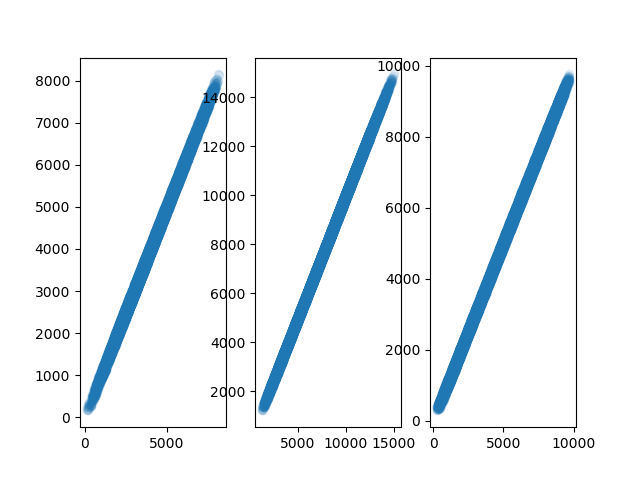

In [47]:
# Show affine coordinate similarity
plotting.plot_correspondence(affine_keypts_um, moving_keypts_um)

<IPython.core.display.Javascript object>


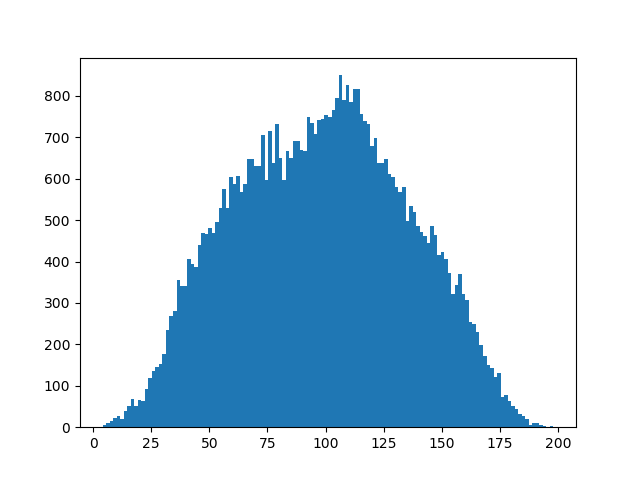

Affine ave. distance [um]: 98.2615294654


In [48]:
# Show residuals after affine
affine_residuals = reg.match_distance(affine_keypts_um,
                                      moving_keypts_um)
plotting.plot_hist(affine_residuals, 128)
print('Affine ave. distance [um]:', affine_residuals.mean())

<IPython.core.display.Javascript object>


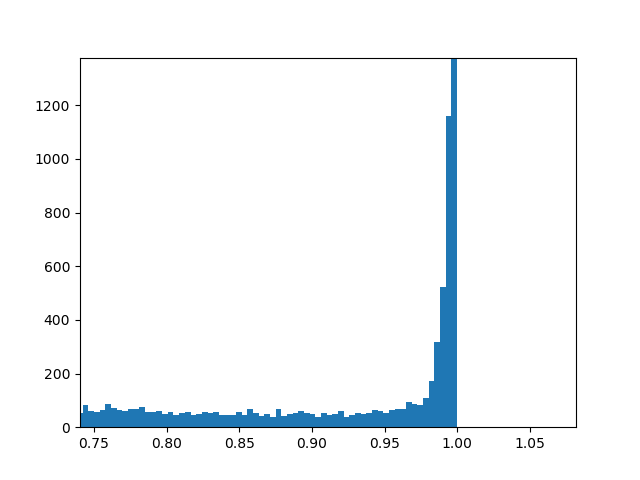

Average coherence: 0.26758495615859057


In [49]:
# Calculate displacement coherence
n_neighbors = 3

coherences = reg.coherence(n_neighbors, 
                           affine_keypts_dist_um, 
                           moving_keypts_dist_um)
plotting.plot_hist(coherences, bins=512)
print('Average coherence: {}'.format(coherences.mean()))

In [58]:
# Filter out incoherent matches
min_coherence = 0.9

coherent_idx = np.where(coherences > min_coherence)
print('Found {} outliers'.format(len(coherences)-len(coherent_idx[0])))

fixed_keypts_coherent = fixed_keypts_dist[coherent_idx]
affine_keypts_coherent = affine_keypts_dist[coherent_idx]
moving_keypts_coherent = moving_keypts_dist[coherent_idx]

fixed_keypts_coherent_um = fixed_keypts_dist_um[coherent_idx]
affine_keypts_coherent_um = affine_keypts_dist_um[coherent_idx]
moving_keypts_coherent_um = moving_keypts_dist_um[coherent_idx]

Found 43783 outliers


<IPython.core.display.Javascript object>


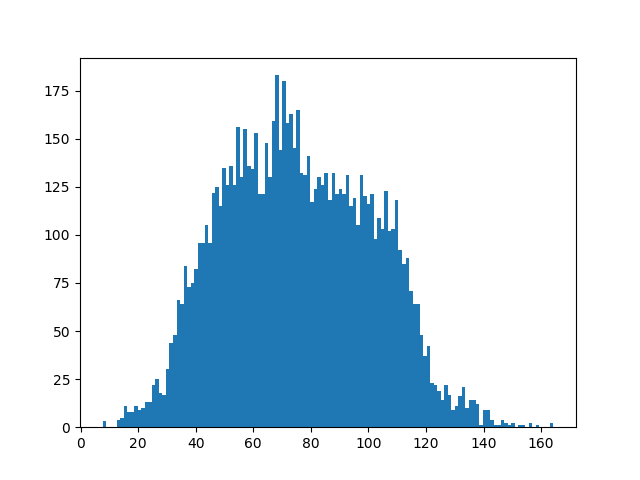

Affine ave. distance [um]: 75.7480439834


In [59]:
# Show residuals after affine
affine_residuals_coherent = reg.match_distance(affine_keypts_um[coherent_idx],
                                               moving_keypts_um[coherent_idx])
plotting.plot_hist(affine_residuals_coherent, 128)
print('Affine ave. distance [um]:', affine_residuals_coherent.mean())

<IPython.core.display.Javascript object>


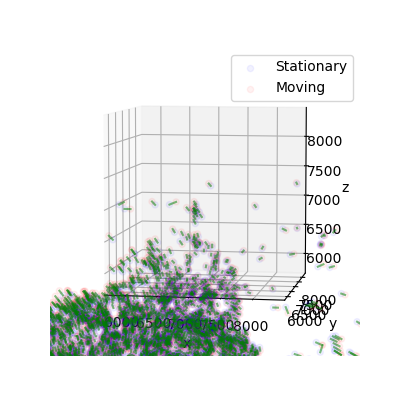

In [51]:
%matplotlib notebook
# Plot filtered matches
plotting.plot_pts(affine_keypts_coherent_um,
                  moving_keypts_coherent_um,
                  0.05,
                  affine_keypts_coherent_um,
                  moving_keypts_coherent_um)

In [53]:
# Save the affine transformation
affine_path = 'affine_transformation.pkl'

pickle_save(os.path.join(working_dir, affine_path), 
            affine_transformation)

In [54]:
# Save the filtered match coordinates
fixed_keypts_path = 'fixed_keypts.npy'
affine_keypts_path = 'affine_keypts.npy'
moving_keypts_path = 'moving_keypts.npy'

np.save(os.path.join(working_dir, fixed_keypts_path), 
        fixed_keypts_coherent)
np.save(os.path.join(working_dir, affine_keypts_path), 
        affine_keypts_coherent)
np.save(os.path.join(working_dir, moving_keypts_path), 
        moving_keypts_coherent)